<a href="https://colab.research.google.com/github/Michaelcortes28/Codigo-de-modelo-Double-Exponential-Smoothing-con-Pycaret./blob/main/CONSUMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [ ]:
!pip install pyspark
!pip install --upgrade pycaret

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pycaret.classification import *
from pycaret.time_series import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from pyspark.sql.functions import to_date
#Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')
#importar spark
from pyspark.sql import SparkSession
#Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Read CSV") \
    .getOrCreate()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lectura de la base

In [ ]:
# Ruta al archivo CSV en Google Drive
file_path_ORIGINAL = '/content/drive/My Drive/BBVA/saldos.csv'
file_path = '/content/drive/My Drive/BBVA/saldoss.csv'

# Leer el archivo CSV usando PySpark
base = spark.read.option("delimiter", ",").csv(file_path, header=True, inferSchema=True).filter((col("cutoff_date") <= "2024-08-01"))

In [ ]:
base.show(2,False)

+-----------+--------------------+--------+-------------+-----------+
|cutoff_date|TIPO_PRODUCTO       |PRODUCTO|SALDO_PUNTUAL|SALDO_MEDIO|
+-----------+--------------------+--------+-------------+-----------+
|2022-01-03 |INVERSION GESTIONADA|TARJETAS|2259873394   |2258709676 |
|2022-01-03 |INVERSION GESTIONADA|CONSUMO |4612457730   |4585634444 |
+-----------+--------------------+--------+-------------+-----------+
only showing top 2 rows



In [ ]:
s = base.toPandas()
s['cutoff_date'] = pd.to_datetime(s['cutoff_date'])
s['cutoff_date'] = s['cutoff_date'].dt.date
ult_his = s['cutoff_date'].max()
pr_pron = ult_his + pd.Timedelta(days=1)
ult_pron = ult_his + pd.Timedelta(days=30)
fechas_test = sorted([ult_his-pd.Timedelta(days=x) for x in range(30)])
fechas_pronostico = sorted([pr_pron+pd.Timedelta(days=x) for x in range((ult_pron-pr_pron).days+1)])
print("Fechas de pronóstico:", fechas_pronostico)

Fechas de pronóstico: [datetime.date(2024, 8, 2), datetime.date(2024, 8, 3), datetime.date(2024, 8, 4), datetime.date(2024, 8, 5), datetime.date(2024, 8, 6), datetime.date(2024, 8, 7), datetime.date(2024, 8, 8), datetime.date(2024, 8, 9), datetime.date(2024, 8, 10), datetime.date(2024, 8, 11), datetime.date(2024, 8, 12), datetime.date(2024, 8, 13), datetime.date(2024, 8, 14), datetime.date(2024, 8, 15), datetime.date(2024, 8, 16), datetime.date(2024, 8, 17), datetime.date(2024, 8, 18), datetime.date(2024, 8, 19), datetime.date(2024, 8, 20), datetime.date(2024, 8, 21), datetime.date(2024, 8, 22), datetime.date(2024, 8, 23), datetime.date(2024, 8, 24), datetime.date(2024, 8, 25), datetime.date(2024, 8, 26), datetime.date(2024, 8, 27), datetime.date(2024, 8, 28), datetime.date(2024, 8, 29), datetime.date(2024, 8, 30), datetime.date(2024, 8, 31)]




##Consumo punta

In [ ]:
#Filtramos el producto a trabajar y el rango de tiempo que vamos a tomar para arreglar la base inicialmente.
consumo = base.filter(col("PRODUCTO") == "CONSUMO") \
                .filter(col("cutoff_date") < "2024-02-01") \
                .filter(~col("cutoff_date").isin("2023-07-04","2023-10-02","2024-01-02"))
#Especificamos el tipo de dato para cada columna.

consumofin = consumo.withColumn("cutoff_date",to_date("cutoff_date", "yyyy-MM-dd"))\
                    .withColumn("SALDO_PUNTUAL",col("SALDO_PUNTUAL").cast("long"))\
                    .withColumn("SALDO_MEDIO",col("SALDO_MEDIO").cast("long"))

#Realizamos el Foward Fill mediante una ventana de tiempo.

min_max_dates = consumofin.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates[0]


rango_df = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha"))\
                            .withColumn("cutoff_date", explode("fecha"))


consumo_df = rango_df.join(consumofin, "cutoff_date", "left_outer").dropDuplicates()


window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)


consumo_completo = consumo_df.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec))\
                             .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))


consumo_punta = consumo_completo.select("cutoff_date", "SALDO_PUNTUAL").orderBy("cutoff_date")

#Convertimos la base rellenada en un entorno pandas.

consumo_punta=consumo_punta.toPandas()

#Construcción modelo de predicción

con=TSForecastingExperiment()

#Definimos el entorno de ejecución y los dias a pronosticar.

con = con.setup(consumo_punta['SALDO_PUNTUAL'],fold=3,fh=30,verbose=False)

##escoger modelo (se deja comentado para que no aparezca en cada ejecución)
#cons=con.compare_models(n_select=3,sort="MAE")
#Crear el modelo escogido
dt_con = con.create_model('ada_cds_dt',verbose=False)
#mejorar los Hiperparametros
nuned_con=con.tune_model(dt_con,verbose=False)
#datos que arroja el modelo
y_pred=con.predict_model(dt_con,verbose=False)
#datos reales
y_train=con.get_config("y_train")
#finalizamos la construcción del modelo
final_con=con.finalize_model(nuned_con)
#Conjunto de predicción
y_predict=con.predict_model(final_con)
#Grafico (se deja comentado para ser validado de ser necesario)
#plot_series(y_train,y_predict,labels=["Train","Test predictions"])
#plt.grid()
#Crear base predicciones
rango_fechas = pd.date_range(start='2024-02-01', end='2024-03-01', freq='D')
y_predict["cutoff_date"]=rango_fechas
y_predict = y_predict[~y_predict['cutoff_date'].isin(["2024-02-29","2024-03-01"])]
y_predict = y_predict.rename(columns={'y_pred': 'SALDO_PUNTUAL'})
y_predict = y_predict[['cutoff_date', 'SALDO_PUNTUAL']]
#Crear base arreglo en febrero
consumo_ = pd.concat([consumo_punta,y_predict], ignore_index=True)
consumo_["Dato"]="HISTORICO"
consumo_['cutoff_date'] = pd.to_datetime(consumo_['cutoff_date'])
consumo_['cutoff_date'] = consumo_['cutoff_date'].dt.date
consumo_

,cutoff_date,SALDO_PUNTUAL,Dato
0,2022-01-03,4.612458e+09,HISTORICO
1,2022-01-04,4.639537e+09,HISTORICO
2,2022-01-05,4.663020e+09,HISTORICO
3,2022-01-06,4.687585e+09,HISTORICO
4,2022-01-07,4.708208e+09,HISTORICO
...,...,...,...
782,2024-02-24,6.914745e+09,HISTORICO
783,2024-02-25,6.913327e+09,HISTORICO
784,2024-02-26,6.911898e+09,HISTORICO
785,2024-02-27,6.910456e+09,HISTORICO


## Pronóstico

In [ ]:
#Filtramos el producto a trabajar y el rango de tiempo que vamos a tomar déspues de arreglar la base.

consumo_2 = base.filter(col("PRODUCTO") == "CONSUMO")\
                .filter((col("cutoff_date") > "2024-02-28"))\
                .filter(~col("cutoff_date").isin(["2023-07-04","2023-10-02","2024-01-02"]))


#Especificamos el tipo de dato para cada columna.

consumofin_2 = consumo_2.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd"))\
                        .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long"))\
                        .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))


#Realizamos el Foward Fill mediante una ventana de tiempo.

min_max_dates_2 = consumofin_2.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates_2[0]


rango_df_2 = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                              .withColumn("cutoff_date", F.explode("fecha"))

consumo_df_2 = rango_df_2.join(consumofin_2, "cutoff_date", "left_outer").dropDuplicates()


window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)


consumo_completo_2 = consumo_df_2.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec))\
                                 .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))


consumo_punta_2 = consumo_completo_2.select("cutoff_date", "SALDO_PUNTUAL").orderBy("cutoff_date")


consumo_punta_2=consumo_punta_2.toPandas()


consumo_punta_2["Dato"]="HISTORICO"

# Añadimos el arreglo de la base.

consumo_punta_=pd.concat([consumo_, consumo_punta_2], ignore_index=True)
consumo_punta_['SALDO_PUNTUAL'] = consumo_punta_['SALDO_PUNTUAL'].astype('int64')
#Construcción prediccion del modelo
con_2=TSForecastingExperiment()
con_2=con_2.setup(consumo_punta_["SALDO_PUNTUAL"], fold=3, fh=30,verbose=False)

#ELEGIR EL MODELO ADECUADO SEGUN LOS DATOS HISTORICOS

#cons_2=con_2.compare_models(n_select=3,sort="MAE")

#Crear el modelo escogido ets
dt_con_2 = con_2.create_model('exp_smooth',verbose=False)
#mejorar los Hiperparametros
tuned_con_2=con_2.tune_model(dt_con_2,verbose=False)
#datos que arroja el modelo
y_pred_2=con_2.predict_model(dt_con_2,verbose=False)
#finalizamos la construccion del modelo
final_con_2=con_2.finalize_model(tuned_con_2)
#Conjunto datos de entrenamiento
y_train_2= con_2.get_config("y_train")
#Conjunto de datos predichos
y_test_2= con_2.get_config("y_test")
y_predict_2=con_2.predict_model(final_con_2)
#Grafico
#plot_series(y_train_2,y_predict_2,labels=["Train","Test predictions"])
#plt.grid()
#crear base para la predicción
y_predict_2["cutoff_date"]=fechas_pronostico
y_predict_2 = y_predict_2.rename(columns={'y_pred': 'SALDO_PUNTUAL'})
y_predict_2 = y_predict_2[['cutoff_date', 'SALDO_PUNTUAL']]
y_test_2 = pd.DataFrame(y_test_2)
# Crear base entrenamiento
y_pred_2["cutoff_date"]=fechas_test
y_pred_2["SALDO_PUNTUAL"] = y_pred_2['y_pred'].rename( 'SALDO_PUNTUAL')
y_pred_2["Dato"]="HISTORICO"
y_pred_2["Real"]=y_test_2['SALDO_PUNTUAL']
del y_pred_2["y_pred"]
#crear base predicciones
y_predict_2['Dato']="PRONOSTICO"
#Crear base final
consumo_final = pd.concat([consumo_,consumo_punta_2], ignore_index=True)
consumo_final = pd.concat([consumo_final,y_predict_2], ignore_index=True)
consumo_final['cutoff_date'] = pd.to_datetime(consumo_final['cutoff_date'])
consumo_final['cutoff_date'] = consumo_final['cutoff_date'].dt.date
consumo_final['producto']="CONSUMO"
consumo_final['SALDO_PUNTUAL'] = consumo_final['SALDO_PUNTUAL'].astype('int64')
consumo_final

,cutoff_date,SALDO_PUNTUAL,Dato,producto
0,2022-01-03,4612457730,HISTORICO,CONSUMO
1,2022-01-04,4639536711,HISTORICO,CONSUMO
2,2022-01-05,4663020124,HISTORICO,CONSUMO
3,2022-01-06,4687585432,HISTORICO,CONSUMO
4,2022-01-07,4708208477,HISTORICO,CONSUMO
...,...,...,...,...
967,2024-08-27,6001333492,PRONOSTICO,CONSUMO
968,2024-08-28,6005318707,PRONOSTICO,CONSUMO
969,2024-08-29,6005559949,PRONOSTICO,CONSUMO
970,2024-08-30,6005420527,PRONOSTICO,CONSUMO


## Error MAPE

In [ ]:
# prompt: haz un codigo en el que calcules el error MAPE siendo que mis y_test_2 son un dataframe con mis valores reales y y_pred_2 una columna de otro dataframe con mis valores futuros

import numpy as np

# Asegúrate de que y_test_2 sea una Serie de pandas y no un DataFrame
y_test_2 = y_test_2['SALDO_PUNTUAL']

# Calcula el MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test_2, y_pred_2['SALDO_PUNTUAL'])
print(f"MAPE: {mape_value}")

MAPE: 0.6231624088544809


## Intervalos de confianza

#### Histograma Valores de pronósticos del modelo.

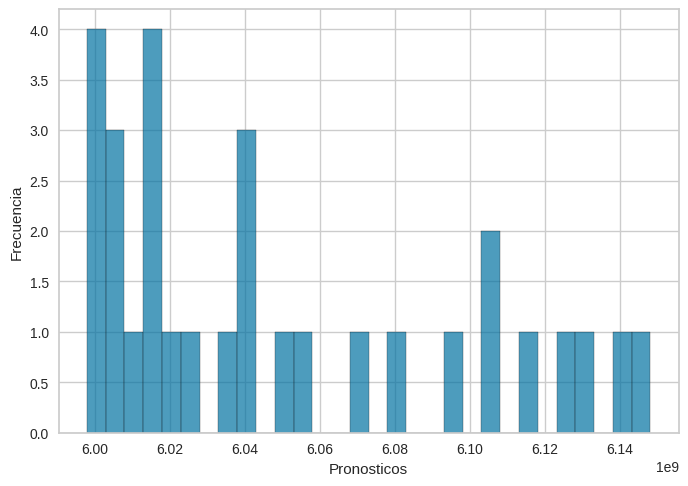

In [ ]:
import matplotlib.pyplot as plt

# Histograma de los residuos
plt.hist(pronosticos, bins=30, edgecolor='k', alpha=0.7,)
#plt.title('Histograma de Residuos Consumo')
plt.xlabel('Pronosticos')
plt.ylabel('Frecuencia')
# Quita el grid
#plt.grid(False)
plt.savefig('/content/drive/My Drive/BBVA/consumo_histogram_residuos.pdf')

plt.show()

#### Bootstrap para crear el IC

In [ ]:
import numpy as np
from scipy import stats

# Supongamos que 'pronosticos' es un array de NumPy con los valores pronosticados
pronosticos = y_predict_2['SALDO_PUNTUAL']
pronosticos = np.array(pronosticos)

# Parámetros
B = 1000  # Número de muestras bootstrap
n = len(pronosticos)  # Tamaño de la muestra de pronósticos

# Almacenar las estadísticas de las muestras bootstrap
bootstrap_means = np.empty(B)

# Generar muestras bootstrap y calcular la media de cada muestra
for i in range(B):
    sample = np.random.choice(pronosticos, size=n, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Calcular la media y desviación estándar de la distribución bootstrap
mean_bootstrap = np.mean(bootstrap_means)
std_bootstrap = np.std(bootstrap_means)

# Calcular el intervalo de confianza utilizando la distribución normal
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)
lower_bound = mean_bootstrap - z_critical * std_bootstrap
upper_bound = mean_bootstrap + z_critical * std_bootstrap

print(f"Intervalo de confianza del 95% para la media de los pronósticos: [{lower_bound:.4f}, {upper_bound:.4f}]")

Intervalo de confianza del 95% para la media de los pronósticos: [6032904092.1218, 6066159637.0345]


#### Histograma Distribución de medias de pronósticos Bootstrap

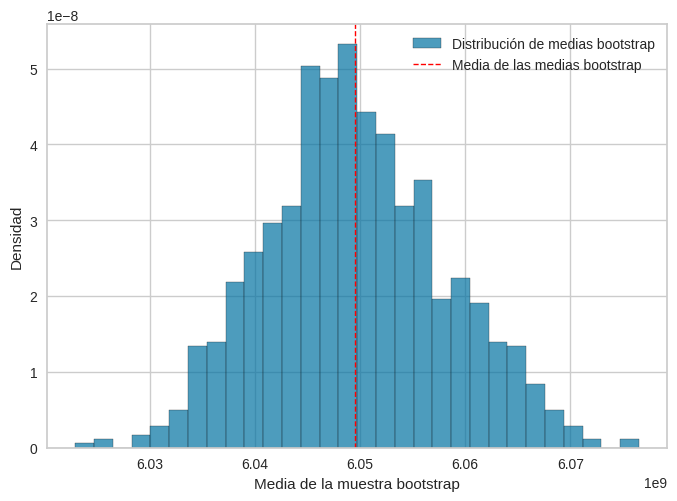

In [ ]:
import matplotlib.pyplot as plt

# ... (tu código existente)

# Crear el histograma
plt.hist(bootstrap_means, bins=30,edgecolor='k', density=True, alpha=0.7, label='Distribución de medias bootstrap')

# Agregar una línea vertical para la media de las medias bootstrap
plt.axvline(mean_bootstrap, color='red', linestyle='dashed', linewidth=1, label='Media de las medias bootstrap')

# Personalizar el gráfico
plt.xlabel('Media de la muestra bootstrap')
plt.ylabel('Densidad')
#plt.title('Distribución de las Medias de las Muestras Bootstrap')
plt.legend()
plt.savefig('/content/drive/My Drive/BBVA/consumo_histogram_residuos_boots.pdf')

# Mostrar el gráfico
plt.show()



##Consumo medio

In [ ]:
consumo = base.filter(col("PRODUCTO") == "CONSUMO") \
                .filter(col("cutoff_date") < "2024-02-01") \
                .filter(~col("cutoff_date").isin("2023-07-04","2023-10-02","2024-01-02","2023-04-03","2023-05-23","2023-05-29","2023-02-27","2023-04-26","2023-04-27","2023-04-28"))

# Preparar datos para `SALDO_MEDIO`
consumofin = consumo.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd")) \
                    .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long")) \
                    .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))

# Obtener fechas mínimas y máximas
min_max_dates = consumofin.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates[0]

# Crear rango de fechas
rango_df = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                            .withColumn("cutoff_date", explode("fecha"))

# Unir con datos históricos
consumo_df = rango_df.join(consumofin, "cutoff_date", "left_outer").dropDuplicates()

# Definir la ventana de datos
window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)

# Completar datos con el último valor disponible
consumo_completo = consumo_df.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec)) \
                             .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))

# Seleccionar y ordenar `SALDO_MEDIO`
consumo_medio = consumo_completo.select("cutoff_date", "SALDO_MEDIO").orderBy("cutoff_date")

# Convertir a pandas
consumo_medio = consumo_medio.toPandas()

# Construcción del modelo de predicción para `SALDO_MEDIO`
con = TSForecastingExperiment()
con = con.setup(consumo_medio['SALDO_MEDIO'], fold=3, fh=30, verbose=False)

# Escoger modelo
# cons = con.compare_models(n_select=3, sort="MAE")
# Crear el modelo escogido
dt_con = con.create_model('ada_cds_dt', verbose=False)

# Mejorar los hiperparámetros
nuned_con = con.tune_model(dt_con, verbose=False)

# Datos del modelo
y_pred = con.predict_model(dt_con, verbose=False)

# Datos reales
y_train = con.get_config("y_train")

# Finalizar la construcción del modelo
final_con = con.finalize_model(nuned_con)

# Conjunto de predicción
y_predict = con.predict_model(final_con)

# Crear base de predicciones
rango_fechas = pd.date_range(start='2024-02-01', end='2024-03-01', freq='D')
y_predict["cutoff_date"] = rango_fechas
y_predict = y_predict[~y_predict['cutoff_date'].isin(["2024-02-29", "2024-03-01"])]
y_predict = y_predict.rename(columns={'y_pred': 'SALDO_MEDIO'})
y_predict = y_predict[['cutoff_date', 'SALDO_MEDIO']]

# Crear base de datos con los datos históricos y predicciones
consumo__ = pd.concat([consumo_medio, y_predict], ignore_index=True)
consumo__["Dato"] = "HISTORICO"
consumo__['cutoff_date'] = pd.to_datetime(consumo__['cutoff_date'])
consumo__['cutoff_date'] = consumo__['cutoff_date'].dt.date

consumo__


,cutoff_date,SALDO_MEDIO,Dato
0,2022-01-03,4.585634e+09,HISTORICO
1,2022-01-04,4.599119e+09,HISTORICO
2,2022-01-05,4.611899e+09,HISTORICO
3,2022-01-06,4.624513e+09,HISTORICO
4,2022-01-07,4.636470e+09,HISTORICO
...,...,...,...
782,2024-02-24,7.160592e+09,HISTORICO
783,2024-02-25,7.164847e+09,HISTORICO
784,2024-02-26,7.166703e+09,HISTORICO
785,2024-02-27,7.171517e+09,HISTORICO


## Pronostico

In [ ]:
consumo_2 = base.filter(col("PRODUCTO") == "CONSUMO")\
                .filter((col("cutoff_date") > "2024-02-28"))\
                .filter(~col("cutoff_date").isin(["2023-07-04","2023-10-02","2024-01-02","2023-04-03","2023-05-23","2023-05-29","2023-02-27","2023-04-26","2023-04-27","2023-04-28"]))


consumofin_2 = consumo_2.withColumn("cutoff_date", to_date("cutoff_date", "yyyy-MM-dd"))\
                        .withColumn("SALDO_PUNTUAL", col("SALDO_PUNTUAL").cast("long"))\
                        .withColumn("SALDO_MEDIO", col("SALDO_MEDIO").cast("long"))


min_max_dates_2 = consumofin_2.select(min("cutoff_date").alias("min_fecha"), max("cutoff_date").alias("max_fecha")).collect()
min_fecha, max_fecha = min_max_dates_2[0]


rango_df_2 = spark.range(0, 1).select(F.expr(f"sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day) as fecha")) \
                              .withColumn("cutoff_date", F.explode("fecha"))

consumo_df_2 = rango_df_2.join(consumofin_2, "cutoff_date", "left_outer").dropDuplicates()


window_spec = Window.orderBy("cutoff_date").rowsBetween(Window.unboundedPreceding, 0)


consumo_completo_2 = consumo_df_2.withColumn("SALDO_PUNTUAL", F.last("SALDO_PUNTUAL", ignorenulls=True).over(window_spec))\
                                 .withColumn("SALDO_MEDIO", F.last("SALDO_MEDIO", ignorenulls=True).over(window_spec))


consumo_punta_2 = consumo_completo_2.select("cutoff_date", "SALDO_MEDIO").orderBy("cutoff_date")


consumo_punta_2=consumo_punta_2.toPandas()

consumo_punta_2["Dato"]="HISTORICO"
consumo_punta_=pd.concat([consumo__, consumo_punta_2], ignore_index=True)
consumo_punta_['SALDO_MEDIO'] = consumo_punta_['SALDO_MEDIO'].astype('int64')
#Construcción prediccion del modelo
con_2=TSForecastingExperiment()
con_2=con_2.setup(consumo_punta_["SALDO_MEDIO"], fold=3, fh=30,verbose=False)
#ELEGIR EL MODELO ADECUADO SEGUN LOS DATOS HISTORICOS


#cons_2=con_2.compare_models(n_select=3,sort="MAE")


#Crear el modelo escogido ets
dt_con_2 = con_2.create_model('exp_smooth',verbose=False)
#mejorar los Hiperparametros
tuned_con_2=con_2.tune_model(dt_con_2,verbose=False)
#datos que arroja el modelo
y_pred_2=con_2.predict_model(dt_con_2,verbose=False)
#finalizamos la construccion del modelo
final_con_2=con_2.finalize_model(tuned_con_2)
#Conjunto datos de entrenamiento
y_train_2= con_2.get_config("y_train")
#Conjunto de datos predichos
y_test_2= con_2.get_config("y_test")
y_predict_2=con_2.predict_model(final_con_2)
#Grafico
#plot_series(y_train_2,y_predict_2,labels=["Train","Test predictions"])
#plt.grid()
#crear base para la predicción
y_predict_2["cutoff_date"]=fechas_pronostico
y_predict_2 = y_predict_2.rename(columns={'y_pred': 'SALDO_MEDIO'})
y_predict_2 = y_predict_2[['cutoff_date', 'SALDO_MEDIO']]
#intervalos de confianza
y_test_2 = pd.DataFrame(y_test_2)
# Calcular los residuos del modelo
residuos_2 = consumo_punta_["SALDO_MEDIO"] - y_pred_2['y_pred']
residuos_2=residuos_2.dropna()
# Crear base entrenamiento
y_pred_2["cutoff_date"]=fechas_test
y_pred_2["SALDO_MEDIO"] = y_pred_2['y_pred'].rename( 'SALDO_MEDIO')
y_pred_2["Dato"]="HISTORICO"
y_pred_2["Real"]=y_test_2['SALDO_MEDIO']
del y_pred_2["y_pred"]
#crear base predicciones
y_predict_2['Dato']="PRONOSTICO"
#Crear base final
consumo_final_ = pd.concat([consumo__,consumo_punta_2], ignore_index=True)
consumo_final_ = pd.concat([consumo_final_,y_predict_2], ignore_index=True)
consumo_final_['cutoff_date'] = pd.to_datetime(consumo_final_['cutoff_date'])
consumo_final_['cutoff_date'] = consumo_final_['cutoff_date'].dt.date
consumo_final_['producto']="CONSUMO"
consumo_final_['SALDO_MEDIO'] = consumo_final_['SALDO_MEDIO'].astype('int64')
consumo_final_

,cutoff_date,SALDO_MEDIO,Dato,producto
0,2022-01-03,4585634444,HISTORICO,CONSUMO
1,2022-01-04,4599118562,HISTORICO,CONSUMO
2,2022-01-05,4611898875,HISTORICO,CONSUMO
3,2022-01-06,4624513300,HISTORICO,CONSUMO
4,2022-01-07,4636469754,HISTORICO,CONSUMO
...,...,...,...,...
967,2024-08-27,6149802742,PRONOSTICO,CONSUMO
968,2024-08-28,6147167759,PRONOSTICO,CONSUMO
969,2024-08-29,6148269721,PRONOSTICO,CONSUMO
970,2024-08-30,6145967098,PRONOSTICO,CONSUMO


## Error MAPE


In [ ]:
# prompt: haz un codigo en el que calcules el error MAPE siendo que mis y_test_2 son un dataframe con mis valores reales y y_pred_2 una columna de otro dataframe con mis valores futuros

import numpy as np

# Asegúrate de que y_test_2 sea una Serie de pandas y no un DataFrame
y_test_2 = y_test_2['SALDO_MEDIO']

# Calcula el MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test_2, y_pred_2['SALDO_MEDIO'])
print(f"MAPE: {mape_value}")

MAPE: 1.100333772348863


## Intervalos de confianza

In [ ]:
import numpy as np
from scipy import stats

# Supongamos que 'pronosticos' es un array de NumPy con los valores pronosticados
pronosticos = y_predict_2['SALDO_MEDIO']
pronosticos = np.array(pronosticos)

# Parámetros
B = 1000  # Número de muestras bootstrap
n = len(pronosticos)  # Tamaño de la muestra de pronósticos

# Almacenar las estadísticas de las muestras bootstrap
bootstrap_means = np.empty(B)

# Generar muestras bootstrap y calcular la media de cada muestra
for i in range(B):
    sample = np.random.choice(pronosticos, size=n, replace=True)
    bootstrap_means[i] = np.mean(sample)

# Calcular la media y desviación estándar de la distribución bootstrap
mean_bootstrap = np.mean(bootstrap_means)
std_bootstrap = np.std(bootstrap_means)

# Calcular el intervalo de confianza utilizando la distribución normal
alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha/2)
lower_bound = mean_bootstrap - z_critical * std_bootstrap
upper_bound = mean_bootstrap + z_critical * std_bootstrap

print(f"Intervalo de confianza del 95% para la media de los pronósticos: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Gráfico Ponóstico Series de tiempo para ambos saldos.

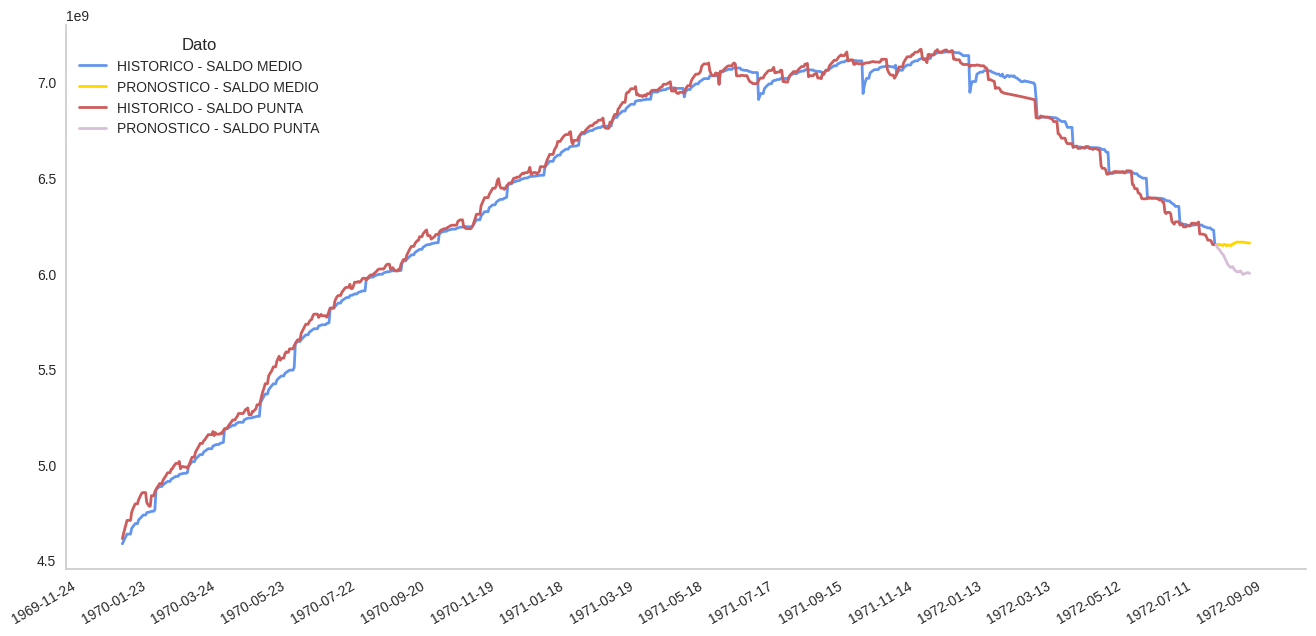

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ajusta el índice de los DataFrames
#consumo_final.set_index('cutoff_date', inplace=True)
#consumo_final_.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores = {'HISTORICO': 'cornflowerblue', 'PRONOSTICO': 'gold'}
colores_ = {'HISTORICO': 'indianred', 'PRONOSTICO': 'thistle'}

# Crea una nueva figura
plt.figure(figsize=(16, 8))

# Grafica SALDO_MEDIO para cada tipo de dato
for Dato, color in colores.items():
    subset = consumo_final_[consumo_final_['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_MEDIO'], label=f'{Dato} - SALDO MEDIO', color=color, linewidth=2)

# Grafica SALDO_PUNTUAL para cada tipo de dato
for Dato, color in colores_.items():
    subset = consumo_final[consumo_final['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_PUNTUAL'], label=f'{Dato} - SALDO PUNTA', color=color, linewidth=2)

# Establece el formato de las fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar solo algunas fechas (cada 60 días en este caso)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()  # Ajusta las fechas para que no se superpongan

# Ajusta el rango del eje x para que empiece desde el 1 de enero de 2023
#plt.xlim(pd.Timestamp('2023-01-01'), plt.gca().get_xlim()[1])

# Añade detalles al gráfico
#plt.title('SALDOS CONSUMO LIBRE')
#plt.xlabel('Fecha')
#plt.ylabel('Saldo')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico
plt.savefig('/content/drive/My Drive/BBVA/consumo_combinado.pdf')

# Muestra el gráfico
plt.show()


# Rendimiento

### Rendimiento-PUNTA

In [ ]:
# Lectura de archivos CSV
abril = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_abril.csv', header=True, inferSchema=True)
mayo = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_mayo.csv', header=True, inferSchema=True)
junio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_junio.csv', header=True, inferSchema=True)
julio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_julio.csv', header=True, inferSchema=True)
agosto = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_/saldos_agosto.csv', header=True, inferSchema=True)

# Unir todos los DataFrames y filtrar las fechas posteriores a "2024-03-31"
a = abril.union(mayo)
a = a.union(junio)
a = a.union(julio)
a = a.union(agosto)
a = a.filter(col("cutoff_date")>"2024-03-31").dropDuplicates(["cutoff_date","SALDO_PUNTUAL","Dato"])
# Obtener la fecha mínima y máxima
min_fecha = a.agg(F.min("cutoff_date")).first()[0]
max_fecha = a.agg(F.max("cutoff_date")).first()[0]
# Generar un rango completo de fechas
rango_fechas = spark.sql(f"SELECT explode(sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day)) as cutoff_date")
# Crear un DataFrame con todas las combinaciones posibles de fechas, productos y 'Dato'
df_completo = a.select("Dato", "producto").distinct().crossJoin(rango_fechas)
df_completo = df_completo.join(a, on=["cutoff_date","Dato", "producto"], how="left")
window_spec = Window.partitionBy("Dato", "producto").orderBy("cutoff_date")
df_final = df_completo.withColumn("SALDO_PUNTUAL", when(col("SALDO_PUNTUAL").isNull(), lead("SALDO_PUNTUAL", 1).over(window_spec)).otherwise(col("SALDO_PUNTUAL")))
df_final = df_final.select("cutoff_date","SALDO_PUNTUAL","Dato","producto")
df_final.show()

+-----------+-------------+---------+--------+
|cutoff_date|SALDO_PUNTUAL|     Dato|producto|
+-----------+-------------+---------+--------+
| 2024-04-01|   6659807751|HISTORICO| CONSUMO|
| 2024-04-02|   6664829089|HISTORICO| CONSUMO|
| 2024-04-03|   6664766495|HISTORICO| CONSUMO|
| 2024-04-04|   6666464842|HISTORICO| CONSUMO|
| 2024-04-05|   6654438122|HISTORICO| CONSUMO|
| 2024-04-06|   6654438122|HISTORICO| CONSUMO|
| 2024-04-07|   6654438122|HISTORICO| CONSUMO|
| 2024-04-08|   6657687503|HISTORICO| CONSUMO|
| 2024-04-09|   6658784245|HISTORICO| CONSUMO|
| 2024-04-10|   6656364593|HISTORICO| CONSUMO|
| 2024-04-11|   6654736822|HISTORICO| CONSUMO|
| 2024-04-12|   6664053191|HISTORICO| CONSUMO|
| 2024-04-13|   6664053191|HISTORICO| CONSUMO|
| 2024-04-14|   6664053191|HISTORICO| CONSUMO|
| 2024-04-15|   6653319912|HISTORICO| CONSUMO|
| 2024-04-16|   6653323341|HISTORICO| CONSUMO|
| 2024-04-17|   6651815503|HISTORICO| CONSUMO|
| 2024-04-18|   6648597007|HISTORICO| CONSUMO|
| 2024-04-19|

In [ ]:
# Pivotar el DataFrame
df_final_1 = df_final.groupBy(["cutoff_Date","producto"]).pivot("Dato").agg(F.first("SALDO_PUNTUAL")).orderBy("cutoff_date").fillna(0)

df_final_1= df_final_1.withColumn("Precision", col("PRONOSTICO") - col("HISTORICO"))
df_final_1 = df_final_1.toPandas()
df_final_1['HISTORICO']=df_final_1['HISTORICO'].astype('int64')
df_final_1['Precision']=df_final_1['Precision'].astype('int64')
#sal_1 = '/content/drive/My Drive/BBVA/saldos_rendimiento/rendimiento_saldos_abril.csv'
#df_final_1.to_csv(sal_1, index=False)

In [ ]:
df_final_1

,cutoff_Date,producto,HISTORICO,PRONOSTICO,Precision
0,2024-04-01,CONSUMO,6659807751,6670483097,10675346
1,2024-04-02,CONSUMO,6664829089,6665422117,593028
2,2024-04-03,CONSUMO,6664766495,6663523057,-1243438
3,2024-04-04,CONSUMO,6666464842,6663023670,-3441172
4,2024-04-05,CONSUMO,6654438122,6657774183,3336061
...,...,...,...,...,...
148,2024-08-27,CONSUMO,0,6001296504,6001296504
149,2024-08-28,CONSUMO,0,6005280317,6005280317
150,2024-08-29,CONSUMO,0,6005520167,6005520167
151,2024-08-30,CONSUMO,0,6005379365,6005379365


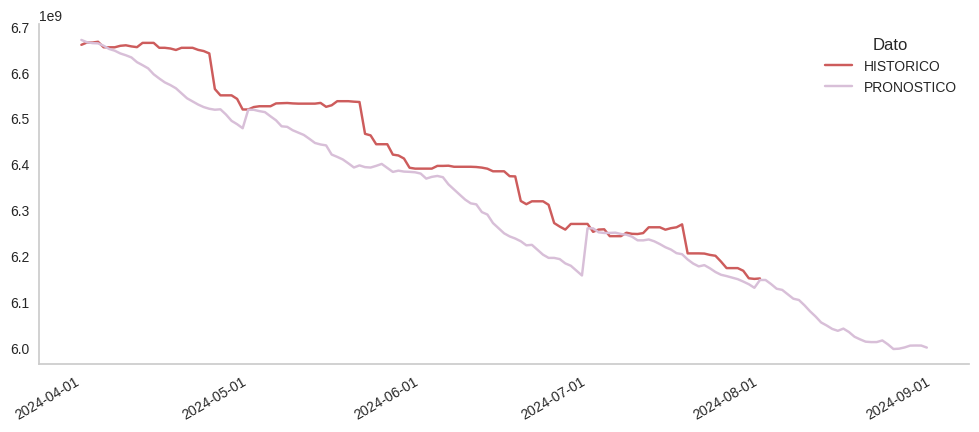

In [ ]:
df_consumo = df_final.filter(col("producto")=="CONSUMO")
df_consumo = df_consumo.toPandas()
# Convertir la columna 'cutoff_date' a tipo de dato datetime si aún no está convertido
df_consumo['cutoff_date'] = pd.to_datetime(df_consumo['cutoff_date'])

# Configura el índice para el DataFrame
df_consumo.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores = {'HISTORICO': 'indianred', 'PRONOSTICO': 'thistle'}

# Crea una nueva figura
plt.figure(figsize=(12, 5))

# Grafica cada tipo de dato con su color correspondiente
for Dato, color in colores.items():
    subset = df_consumo[df_consumo['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_PUNTUAL'], label=Dato, color=color)

# Añade detalles al gráfico
#plt.title('Saldo Puntual por Tipo de Dato')
#plt.xlabel('Fecha')
#plt.ylabel('Saldo')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Establece el formato de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar algunas fechas claramente (cada 2 meses en este caso)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico como un archivo PDF
#plt.savefig('/content/drive/My Drive/BBVA/Rendimiento_consumo_punta.pdf')

# Muestra el gráfico
plt.show()

## RENDIMIENTO-Medio

In [ ]:
# Lectura de archivos CSV
abril = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_abril.csv', header=True, inferSchema=True)
mayo = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_mayo.csv', header=True, inferSchema=True)
junio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_junio.csv', header=True, inferSchema=True)
julio = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_julio.csv', header=True, inferSchema=True)
agosto = spark.read.option("delimiter", ",").csv('/content/drive/My Drive/BBVA/saldos_medio/saldos_agosto.csv', header=True, inferSchema=True)

# Unir todos los DataFrames y filtrar las fechas posteriores a "2024-03-31"
a = abril.union(mayo)
a = a.union(junio)
a = a.union(julio)
a = a.union(agosto)
a = a.filter(col("cutoff_date")>"2024-03-31").dropDuplicates(["cutoff_date","SALDO_MEDIO","Dato"])
# Obtener la fecha mínima y máxima
min_fecha = a.agg(F.min("cutoff_date")).first()[0]
max_fecha = a.agg(F.max("cutoff_date")).first()[0]
# Generar un rango completo de fechas
rango_fechas = spark.sql(f"SELECT explode(sequence(to_date('{min_fecha}'), to_date('{max_fecha}'), interval 1 day)) as cutoff_date")
# Crear un DataFrame con todas las combinaciones posibles de fechas, productos y 'Dato'
df_completo = a.select("Dato", "producto").distinct().crossJoin(rango_fechas)
df_completo = df_completo.join(a, on=["cutoff_date","Dato", "producto"], how="left")
window_spec = Window.partitionBy("Dato", "producto").orderBy("cutoff_date")
df_final = df_completo.withColumn("SALDO_MEDIO", when(col("SALDO_MEDIO").isNull(), lead("SALDO_MEDIO", 1).over(window_spec)).otherwise(col("SALDO_MEDIO")))
df_final = df_final.select("cutoff_date","SALDO_MEDIO","Dato","producto")
df_final.show()

+-----------+-----------+---------+--------+
|cutoff_date|SALDO_MEDIO|     Dato|producto|
+-----------+-----------+---------+--------+
| 2024-04-01| 6659807751|HISTORICO| CONSUMO|
| 2024-04-02| 6662318420|HISTORICO| CONSUMO|
| 2024-04-03| 6663134445|HISTORICO| CONSUMO|
| 2024-04-04| 6663967044|HISTORICO| CONSUMO|
| 2024-04-05| 6662061260|HISTORICO| CONSUMO|
| 2024-04-06| 6662061260|HISTORICO| CONSUMO|
| 2024-04-07| 6662061260|HISTORICO| CONSUMO|
| 2024-04-08| 6659608755|HISTORICO| CONSUMO|
| 2024-04-09| 6659517142|HISTORICO| CONSUMO|
| 2024-04-10| 6659201888|HISTORICO| CONSUMO|
| 2024-04-11| 6658795972|HISTORICO| CONSUMO|
| 2024-04-12| 6659234074|HISTORICO| CONSUMO|
| 2024-04-13| 6659234074|HISTORICO| CONSUMO|
| 2024-04-14| 6659234074|HISTORICO| CONSUMO|
| 2024-04-15| 6659482345|HISTORICO| CONSUMO|
| 2024-04-16| 6659097407|HISTORICO| CONSUMO|
| 2024-04-17| 6658669059|HISTORICO| CONSUMO|
| 2024-04-18| 6658109501|HISTORICO| CONSUMO|
| 2024-04-19| 6657856174|HISTORICO| CONSUMO|
| 2024-04-

In [ ]:
# Pivotar el DataFrame
df_final_1 = df_final.groupBy(["cutoff_Date","producto"]).pivot("Dato").agg(F.first("SALDO_MEDIO")).orderBy("cutoff_date").fillna(0)

df_final_1= df_final_1.withColumn("Precision", col("PRONOSTICO") - col("HISTORICO"))
df_final_1 = df_final_1.toPandas()
df_final_1['HISTORICO']=df_final_1['HISTORICO'].astype('int64')
df_final_1['Precision']=df_final_1['Precision'].astype('int64')
sal_1 = '/content/drive/My Drive/BBVA/saldos_rendimiento/rendimiento_saldos_abril_MEDIO.csv'
df_final_1.to_csv(sal_1, index=False)
df_final_1

,cutoff_Date,producto,HISTORICO,PRONOSTICO,Precision
0,2024-04-01,CONSUMO,6659807751,6759516184,99708433
1,2024-04-02,CONSUMO,6662318420,6753303508,90985088
2,2024-04-03,CONSUMO,6663134445,6747591617,84457172
3,2024-04-04,CONSUMO,6663967044,6742013413,78046369
4,2024-04-05,CONSUMO,6662061260,6736828063,74766803
...,...,...,...,...,...
148,2024-08-27,CONSUMO,0,6008568293,6008568293
149,2024-08-28,CONSUMO,0,5996266546,5996266546
150,2024-08-29,CONSUMO,0,5992267591,5992267591
151,2024-08-30,CONSUMO,0,5986322962,5986322962


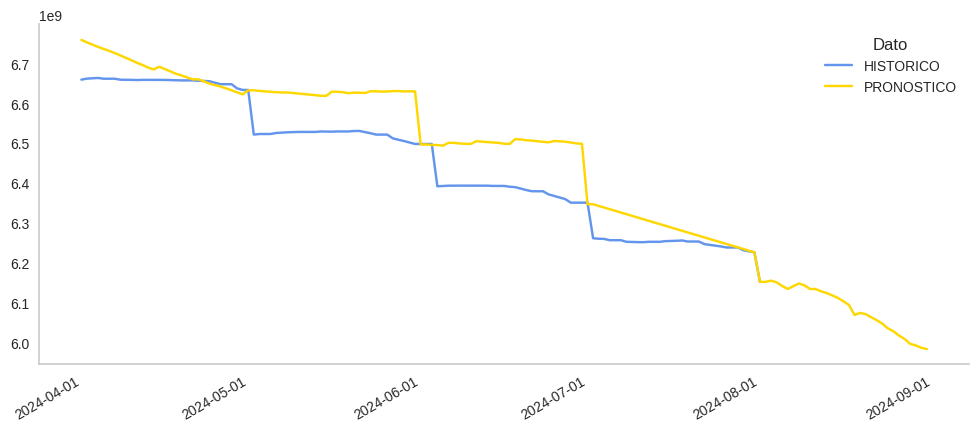

In [ ]:
df_consumo = df_final.filter(col("producto")=="CONSUMO")
df_consumo = df_consumo.toPandas()
# Convertir la columna 'cutoff_date' a tipo de dato datetime si aún no está convertido
df_consumo['cutoff_date'] = pd.to_datetime(df_consumo['cutoff_date'])

# Configura el índice para el DataFrame
df_consumo.set_index('cutoff_date', inplace=True)

# Define los colores para cada tipo de dato
colores = {'HISTORICO': 'cornflowerblue', 'PRONOSTICO': 'gold'}

# Crea una nueva figura
plt.figure(figsize=(12, 5))

# Grafica cada tipo de dato con su color correspondiente
for Dato, color in colores.items():
    subset = df_consumo[df_consumo['Dato'] == Dato]
    plt.plot(subset.index, subset['SALDO_MEDIO'], label=Dato, color=color)

# Añade detalles al gráfico
#plt.title('Saldo Puntual por Tipo de Dato')
#plt.xlabel('Fecha')
#plt.ylabel('Saldo')
plt.legend(title='Dato')

# Quita el grid
plt.grid(False)

# Establece el formato de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Establece el localizador para mostrar algunas fechas claramente (cada 2 meses en este caso)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Ajusta las fechas para que no se superpongan
plt.gcf().autofmt_xdate()

# Oculta los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Guarda el gráfico como un archivo PDF

#plt.savefig('/content/drive/My Drive/BBVA/Rendimiento_consumo_medio.pdf')

# Muestra el gráfico
plt.show()